# SVM
Training auf IDS17 80%  
Validierung auf IDS17 10%   
Test auf IDS17 10%  

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

# Hyperparameter Tuning durchführen
hyperparameter_tuning = False

### Laden von IDS17

In [3]:
# IDS17 Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
ids17 = pd.read_parquet(os.path.join(parquet_verzeichnis_ids17 + '_prep_0'))
print("Class distribution\n{}".format(ids17.Label.value_counts()))

Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Web Attack - Brute Force             73
Web Attack - XSS                     18
Web Attack - SQL                     13
Name: count, dtype: int64


In [4]:
print(ids17.shape)
print(ids17.columns)

(1923167, 84)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

### Trennen von Features und Labels

In [5]:
X = ids17.iloc[:, :-1]  # Alle Spalten außer der letzten
print(f"Form von X: {X.shape}")
y = ids17.iloc[:, -1]   # Die letzte Spalte
print(f"Form von y: {y.shape}")

Form von X: (1923167, 83)
Form von y: (1923167,)


### Label Encoding für y

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Einzigartige Labels: {label_encoder.classes_}")
print(f"Kodierte Labels: {np.unique(y_encoded)}")

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Form von X: {X.shape}")
print(f"Form von X_scaled: {X_scaled.shape}")

Form von X: (1923167, 83)
Form von X_scaled: (1923167, 83)


### Aufteilen der Daten in Trainings- und Testdatensätze

In [8]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

print(f"Form von X_train: {X_train.shape}")
print(f"Form von X_test: {X_test.shape}")

Form von X_train: (1538533, 83)
Form von X_test: (384634, 83)


### Überprüfen der Klassenverteilung

In [9]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 1266048 Beispiele (82.29%)
  Klasse 1: 589 Beispiele (0.04%)
  Klasse 2: 76115 Beispiele (4.95%)
  Klasse 3: 6054 Beispiele (0.39%)
  Klasse 4: 126774 Beispiele (8.24%)
  Klasse 5: 3087 Beispiele (0.20%)
  Klasse 6: 57414 Beispiele (3.73%)
  Klasse 7: 2369 Beispiele (0.15%)
  Klasse 8: 58 Beispiele (0.00%)
  Klasse 9: 11 Beispiele (0.00%)
  Klasse 10: 14 Beispiele (0.00%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 316513 Beispiele (82.29%)
  Klasse 1: 147 Beispiele (0.04%)
  Klasse 2: 19029 Beispiele (4.95%)
  Klasse 3: 1513 Beispiele (0.39%)
  Klasse 4: 31694 Beispiele (8.24%)
  Klasse 5: 772 Beispiele (0.20%)
  Klasse 6: 14353 Beispiele (3.73%)
  Klasse 7: 592 Beispiele (0.15%)
  Klasse 8: 15 Beispiele (0.00%)
  Klasse 9: 2 Beispiele (0.00%)
  Klasse 10: 4 Beispiele (0.00%)



### Optionales Hyperparameter-Tuning

In [10]:
if hyperparameter_tuning:

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }

    grid_search = GridSearchCV(SVC(
        random_state=42), 
        param_grid, 
        cv=2, 
        scoring='accuracy', 
        n_jobs=24, 
        verbose=10)

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    logging.info(f"Beste Hyperparameter: {grid_search.best_params_}")

### Training mit festen Parametern

In [ ]:
if not hyperparameter_tuning:
    best_model = SVC(C=1, gamma='auto', kernel='poly', random_state=42)
    best_model.fit(X_train, y_train)
# Dauer 262 min

### Evaluierung des Modells auf dem Testdatensatz

In [12]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
logging.info(f"Test-Accuracy: {test_accuracy * 100:.2f}%")
logging.info("\nTest Classification Report:\n" + test_report)

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-05 19:12:55

### Klassifikationsbericht und eine Konfusionsmatrix

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    316513
                 Botnet Ares       0.99      1.00      1.00       147
              DDoS-LOIC-HTTP       1.00      1.00      1.00     19029
               DoS GoldenEye       1.00      0.95      0.97      1513
                    DoS Hulk       1.00      1.00      1.00     31694
               DoS Slowloris       0.99      0.98      0.99       772
Infiltration - NMAP Portscan       1.00      1.00      1.00     14353
              SSH-BruteForce       1.00      0.99      0.99       592
    Web Attack - Brute Force       0.88      1.00      0.94        15
            Web Attack - SQL       0.00      0.00      0.00         2
            Web Attack - XSS       0.75      0.75      0.75         4

                    accuracy                           1.00    384634
                   macro avg       0.87      0.88      0.88    384634
                we

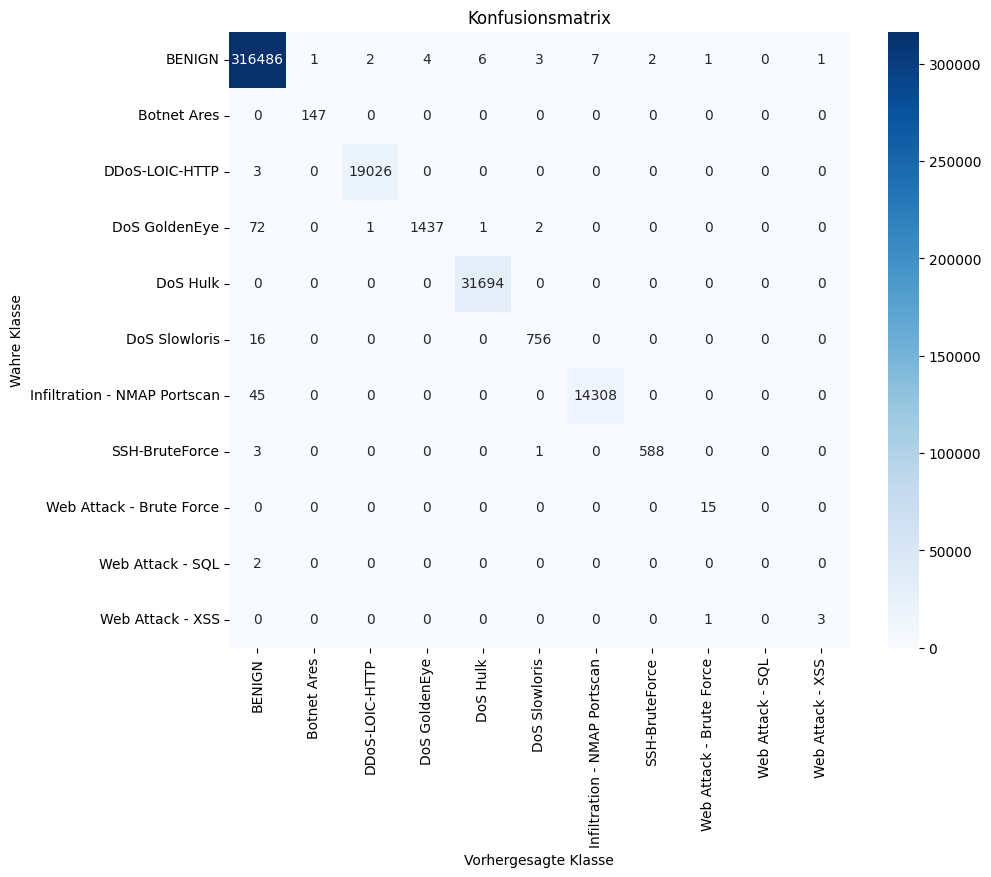

In [13]:
# Klassifikationsbericht
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualisierung der Konfusionsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()

### Speichern des Modells und der Vorverarbeitungsschritte

In [14]:
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_model, 'svm_model.pkl')

['svm_model.pkl']